<a href="https://colab.research.google.com/github/shamimkhaled/mindfulness-meditation-agent/blob/main/Meditation_Agent_to_Generate_Structured_Outputs_with_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the necessary libraries

In [ ]:
!pip install pydantic pytest openai==0.28

  Using cached openai-0.28.0-py3-none-any.whl.metadata (13 kB)
Using cached openai-0.28.0-py3-none-any.whl (76 kB)
  Attempting uninstall: openai
    Found existing installation: openai 1.51.2
    Uninstalling openai-1.51.2:
      Successfully uninstalled openai-1.51.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-openai 0.2.2 requires openai<2.0.0,>=1.40.0, but you have openai 0.28.0 which is incompatible.


# Implement the Mediatation Agent to Generate Structured Outputs

In [ ]:
import openai
from google.colab import userdata
# Securely input your OpenAI API key
api_key = userdata.get('OPENAI_API_KEY')
openai.api_key = api_key


In [ ]:
# List available models
models = openai.Model.list()
print([model['id'] for model in models['data']])

['gpt-4-turbo', 'gpt-4o-mini-2024-07-18', 'gpt-4-turbo-2024-04-09', 'tts-1', 'tts-1-1106', 'chatgpt-4o-latest', 'dall-e-2', 'gpt-4-turbo-preview', 'gpt-3.5-turbo-instruct', 'gpt-4-0125-preview', 'gpt-3.5-turbo-0125', 'gpt-4o-2024-08-06', 'gpt-4o', 'gpt-3.5-turbo', 'babbage-002', 'davinci-002', 'gpt-4o-realtime-preview-2024-10-01', 'dall-e-3', 'gpt-4o-realtime-preview', 'gpt-4o-2024-05-13', 'tts-1-hd', 'tts-1-hd-1106', 'gpt-4-1106-preview', 'text-embedding-ada-002', 'gpt-4o-mini', 'gpt-3.5-turbo-16k', 'text-embedding-3-small', 'text-embedding-3-large', 'whisper-1', 'gpt-3.5-turbo-1106', 'gpt-4-0613', 'gpt-4', 'gpt-3.5-turbo-instruct-0914']


# Define the Pydantic Model

In [ ]:
from pydantic import BaseModel, ValidationError
from typing import List

class Phrase(BaseModel):
    text: str
    pause: int  # milliseconds
    tts_duration: int  # milliseconds

class MeditationScript(BaseModel):
    title: str
    duration: int  # milliseconds
    focus_area: str
    phrases: List[Phrase]
    interval: int  # Default interval between phrases in milliseconds
    engagement: int  # Engagement level(0-100)


# Helper function to call open ai api to validate response

In [ ]:
import openai
import json

def call_openai_for_meditation_script(prompt: str):
    response_format = {
        "type": "json_schema",
        "json_schema": {
            "name": "meditation_response",
            "schema": {
                "type": "object",
                "properties": {
                    "title": {"type": "string"},
                    "duration": {"type": "integer"},  # Duration in milliseconds
                    "focus_area": {"type": "string"},
                    "phrases": {
                        "type": "array",
                        "items": {
                            "type": "object",
                            "properties": {
                                "text": {"type": "string"},
                                "pause": {"type": "integer"},  # Pause in milliseconds
                                "tts_duration": {"type": "integer"}  # Duration for TTS in milliseconds
                            },
                            "required": ["text", "pause", "tts_duration"],
                            "additionalProperties": False
                        }
                    },
                    "interval": {"type": "integer"},  # Default interval between phrases
                    "engagement": {"type": "integer"}  # Engagement level, 0-100
                },
                "required": ["title", "duration", "focus_area", "phrases", "interval", "engagement"],
                "additionalProperties": False
            },
            "strict": True
        }
    }

    try:
        response = openai.ChatCompletion.create(
            model="gpt-4o-2024-08-06",  # Adjust model version
            messages=[
                {"role": "system", "content": "You are a mindfulness meditation assistant that generates structured outputs for meditation scripts."},
                {"role": "user", "content": prompt},
            ],
            response_format=response_format,
            max_tokens=1000,
            temperature=0.7
        )

        structured_output = json.loads(response.choices[0].message['content'])
        return structured_output
    except Exception as e:
        print(f"OpenAI API call failed: {e}")
        return None


# Validated the data with Pydantic

In [ ]:
def validate_meditation_script(data):
    try:
        meditation_script = MeditationScript(**data)
        return meditation_script
    except ValidationError as e:
        print(f"Validation error: {e}")
        return None


# Check the duration

In [ ]:
def check_duration(meditation_script):
    total_time = sum(phrase.pause + phrase.tts_duration for phrase in meditation_script.phrases)

    # Check if total time is close to the specified duration
    if abs(total_time - meditation_script.duration) > meditation_script.interval:
        # If there's a significant difference, return False to indicate an adjustment is needed
        return False
    return True


In [ ]:
def adjust_duration(meditation_script):
    # Create a new prompt to adjust the total duration of the phrases
    adjustment_prompt = (
        f"The total duration of the phrases does not match the requested {meditation_script.duration} milliseconds. "
        f"Please adjust the durations of the phrases in the meditation script so that the total matches {meditation_script.duration} milliseconds, "
        f"while keeping the original structure and intent."
    )
    return adjustment_prompt

In [ ]:
def convert_to_milliseconds(meditation_script: dict) -> dict:
    """
    Convert the duration, pause times, and tts_duration in the meditation script from seconds to milliseconds.
    """
    # Convert duration from seconds to milliseconds
    if "duration" in meditation_script:
        meditation_script["duration"] = meditation_script["duration"] * 1000

    # Convert interval from seconds to milliseconds, if it exists
    if "interval" in meditation_script:
        meditation_script["interval"] = meditation_script["interval"] * 1000

    # Convert each phrase's pause time and tts_duration from seconds to milliseconds
    for phrase in meditation_script.get("phrases", []):
        if "pause" in phrase:
            phrase["pause"] = phrase["pause"] * 1000
        if "tts_duration" in phrase:
            phrase["tts_duration"] = phrase["tts_duration"] * 1000

    return meditation_script


# Generate meditation script

In [ ]:
def generate_meditation_script(prompt: str):
    # Call OpenAI to generate a meditation script based on the user input
    structured_output = call_openai_for_meditation_script(prompt)

    if not structured_output:
        print("Failed to retrieve a structured output from OpenAI.")
        return None

    # Convert duration, pause times, and tts_duration to milliseconds
    converted_output = convert_to_milliseconds(structured_output)
    # Validate the structured response using Pydantic models
    meditation_script = validate_meditation_script(converted_output)

    if not meditation_script:
        print("Failed to validate the structured output.")
        return None

    # Loop to ensure the total duration of the phrases matches the expected duration
    while not check_duration(meditation_script):
        print("Adjusting script as durations don't match...")

        # Generate an adjustment prompt based on the previous meditation script
        adjustment_prompt = adjust_duration(meditation_script)

        # Call OpenAI again with the new prompt to adjust the script
        structured_output = call_openai_for_meditation_script(adjustment_prompt)
        # Convert duration, pause times, and tts_duration to milliseconds
        # converted_output = convert_to_milliseconds(structured_output)


        # Validate the new structured output
        meditation_script = validate_meditation_script(structured_output)

        if not meditation_script:
            print("Failed to validate the adjusted structured output.")
            return None

    # Return the final, validated meditation script with the correct duration
    return meditation_script

# Test the meditation script

In [ ]:
prompt = "Create a 120-second breath awareness meditation focused on relaxation."
meditation_script = generate_meditation_script(prompt)

if meditation_script:
    # Print the structured and validated output
    print(meditation_script.model_dump_json(indent=2))
else:
    print("Failed to generate a valid meditation script.")


Adjusting script as durations don't match...
Adjusting script as durations don't match...
Adjusting script as durations don't match...
Adjusting script as durations don't match...
Adjusting script as durations don't match...
Adjusting script as durations don't match...
Adjusting script as durations don't match...
Adjusting script as durations don't match...
Adjusting script as durations don't match...
Adjusting script as durations don't match...
{
  "title": "Guided Mindfulness Meditation",
  "duration": 120000,
  "focus_area": "Breath Awareness",
  "phrases": [
    {
      "text": "Close your eyes gently and take a deep breath in.",
      "pause": 2000,
      "tts_duration": 6000
    },
    {
      "text": "Hold it for a moment, and now, slowly release.",
      "pause": 3000,
      "tts_duration": 5000
    },
    {
      "text": "Feel the tension leaving your body with each exhale.",
      "pause": 4000,
      "tts_duration": 5000
    },
    {
      "text": "Bring your attention to th

In [ ]:
prompt = "Can u make a 90s mindfulness meditation."
meditation_script = generate_meditation_script(prompt)

if meditation_script:
    # Print the structured and validated output
    print(meditation_script.model_dump_json(indent=2))
else:
    print("Failed to generate a valid meditation script.")


Adjusting script as durations don't match...
Adjusting script as durations don't match...
Adjusting script as durations don't match...
Adjusting script as durations don't match...
{
  "title": "Brief Mindfulness Pause",
  "duration": 90,
  "focus_area": "Breath Awareness",
  "phrases": [
    {
      "text": "Take a deep breath in.",
      "pause": 10,
      "tts_duration": 30
    },
    {
      "text": "Hold it gently.",
      "pause": 10,
      "tts_duration": 20
    },
    {
      "text": "Now, slowly exhale.",
      "pause": 10,
      "tts_duration": 40
    }
  ],
  "interval": 30,
  "engagement": 2
}


# Implement with this LangGraph




In [ ]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

In [ ]:
from google.colab import userdata
langsmith=userdata.get('LANGCHAIN_API_KEY')
print(langsmith)

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


In [ ]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from pydantic import BaseModel, ValidationError
from typing import List
import openai
import os

In [ ]:
os.environ["LANGCHAIN_API_KEY"] = langsmith
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="meditation-agent"

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

# Initialize ChatGroq using the Groq API key
# llm = ChatGroq(groq_api_key=os.getenv("GROQ_API_KEY"), model_name="Gemma2-9b-It")

# Define the state dictionary with "messages" annotated for the message list
class State(TypedDict):
    messages: Annotated[list, add_messages]




In [ ]:
graph_builder=StateGraph(State)


In [ ]:
graph_builder

In [ ]:
def generate_meditation_script(state: State):
    user_input = state["messages"][-1]

    # Call the OpenAI API function
    generated_script = call_openai_for_meditation_script(user_input)

    if generated_script:
        # Ensure that the output is in JSON format
        try:
            meditation_script_json = json.loads(generated_script)
            state["messages"].append(meditation_script_json)
            return {"messages": meditation_script_json}
        except json.JSONDecodeError as e:
            return {"messages": f"Error parsing meditation script JSON: {e}"}
    else:
        return {"messages": "Error generating meditation script."}


# Add the OpenAI node to the state graph
graph_builder.add_node("generate_meditation_script", generate_meditation_script)


# Validation Node to check and validate the structured output using Pydantic
def validate_meditation_script(state: State):
    script_content = state['messages'][-1]

    try:
        # Validate the script content using Pydantic
        validated_script = MeditationScript(**script_content)
        state["messages"].append(validated_script.dict())
        return {"messages": f"Validated meditation script: {validated_script.dict()}"}
    except ValidationError as e:
        return {"messages": f"Validation Error: {e}"}

# Add the validation node to the graph
graph_builder.add_node("validate_meditation_script", validate_meditation_script)


# Adjust the total duration of the meditation script phrases
def adjust_duration(meditation_script):
    # Create a new prompt to adjust the total duration of the phrases
    adjustment_prompt = (
        f"The total duration of the phrases does not match the requested {meditation_script['duration']} milliseconds. "
        f"Please adjust the durations of the phrases in the meditation script so that the total matches {meditation_script['duration']} milliseconds, "
        f"while keeping the original structure and intent."
    )
    return adjustment_prompt

# User feedback and adjustment for meditation script
def adjust_script(state: State):
    # Get the generated meditation script from the state
    meditation_script = state['messages'][-1]

    # Check if the total duration of the phrases matches the requested duration
    total_phrase_duration = sum(phrase['pause'] + phrase['tts_duration'] for phrase in meditation_script['phrases'])

    # If total duration doesn't match, adjust the script
    if total_phrase_duration != meditation_script['duration']:
        adjustment_prompt = adjust_duration(meditation_script)
        # Call OpenAI again to adjust the durations based on the feedback
        adjusted_script = call_openai_for_meditation_script(adjustment_prompt)
        try:
            adjusted_script_json = json.loads(adjusted_script)
            state["messages"].append(adjusted_script_json)
            return {"messages": adjusted_script_json}
        except json.JSONDecodeError as e:
            return {"messages": f"Error parsing adjusted script JSON: {e}"}
    else:
        return {"messages": "No adjustments needed. The script duration matches the requested total."}

# Add adjustment node to the graph
graph_builder.add_node("adjust_script", adjust_script)




In [ ]:
# Define transitions between states
graph_builder.add_edge(START, "generate_meditation_script")
graph_builder.add_edge("generate_meditation_script", "validate_meditation_script")
graph_builder.add_edge("validate_meditation_script", "adjust_script")
graph_builder.add_edge("adjust_script", END)
graph=graph_builder.compile()

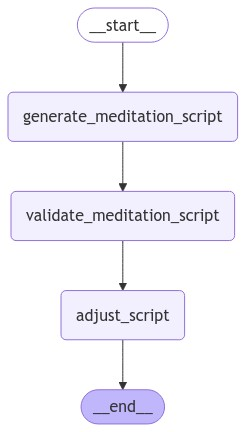

In [ ]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass